# [E-12] 한국어 데이터로 챗봇 만들기

## Step 1. 데이터 수집하기
- **송영숙님이 공개한 챗봇 데이터를 사용**
- **[songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)**

In [1]:
# 필요한 패키지를 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
# github에서 직접 데이터 가져오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.sample(10)

,Q,A,label
256,과일 잘 안 먹게 돼,그래도 먹으려고 노력해보세요.,0
8369,퇴근길에 훅!하고 연락오네.,그분이 미련이 남아있나 봐요.,1
2798,심심한데 뭐 재미있는거 없을까,저랑 놀아요.,0
1900,바람 분다,마음에 부는 바람인지 살펴보세요.,0
1245,더워서 죽을 것 같아,아이스크림 먹어보세요,0
3284,오늘 너무 피곤해,푹 쉬세요.,0
2289,사업 구상,성공하길 바랍니다.,0
11143,좋아하는 사람이 있는데 씨씨야. 만나도 될까?,사랑은 수많은 장벽을 뛰어넘을 수 있어요.,2
7590,이별한지 3개월,많은 시간이 흘렀네요.,1
3592,월요일도 아닌데 차가 너무 많아.,길은 항상 막히는 것 같아요.,0


In [3]:
train_data.tail(10)

,Q,A,label
11813,회사에 좋아하는 남자가 생겼어 어떡하지?,사랑하기 힘든 관계인가봐요.,2
11814,회사에서 어떤 사람이랑 자꾸 눈 마추쳐.,눈 마주치는 게 우연인지 잘 살펴 보세요.,2
11815,회식 중이라고 하는데 연락이 안돼.,정신 없이 바쁠지도 몰라요. 조금만 더 기다려보고 물어보는게 좋을 것 같아요.,2
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.,2
11817,후회 없이 사랑하고 싶어,진심으로 다가가 보세요.,2
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2


In [4]:
print(f'ChatbotData 샘플의 개수 : {len(train_data)}')

ChatbotData 샘플의 개수 : 11823


In [5]:
# null값 확인하기 위해 정보보기
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 15
텍스트의 평균 길이 : 3.587414361837097
요약의 최소 길이 : 1
요약의 최대 길이 : 21
요약의 평균 길이 : 3.6936479742874058


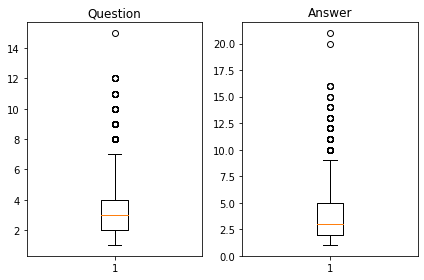

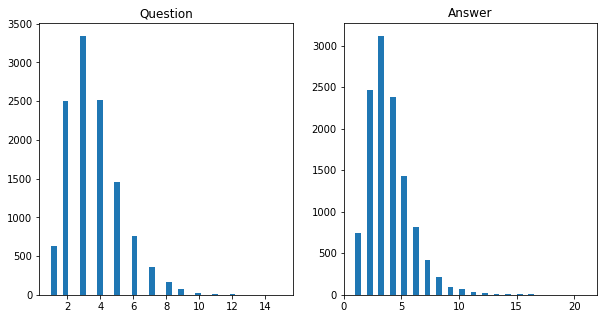

In [6]:
question_len = [len(s.split()) for s in train_data['Q']]
answer_len = [len(s.split()) for s in train_data['A']]

print('텍스트의 최소 길이 : {}'.format(np.min(question_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(question_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(question_len)))
print('요약의 최소 길이 : {}'.format(np.min(answer_len)))
print('요약의 최대 길이 : {}'.format(np.max(answer_len)))
print('요약의 평균 길이 : {}'.format(np.mean(answer_len)))

plt.subplot(1,2,1)
plt.boxplot(question_len)
plt.title('Question')
plt.subplot(1,2,2)
plt.boxplot(answer_len)
plt.title('Answer')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Question')
axs[0].hist(question_len, bins = 40)
axs[1].set_title('Answer')
axs[1].hist(answer_len, bins = 40)
plt.show()

## Step 2. 데이터 전처리하기

In [7]:
# questions에 대한 전처리
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

# answer에 대한 전처리
answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [8]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


## Step 3. SubwordTextEncoder 사용하기

### 3.1 단어장 만들기

In [9]:
# 단어장 만들기
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [10]:
# 정수가 겹치지 않게 하지 위해 단어장의 크기와 그보다 1이 큰 수를 번호로 부여
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2

In [11]:
# START_TOKEN, END_TOKEN 번호, VOCAB_SIZE 출력
print(f'START_TOKEN 번호 : {START_TOKEN}')
print(f'END_TOKEN 번호 : {END_TOKEN}')
print(f'VOCAB_SIZE : {VOCAB_SIZE}')

START_TOKEN 번호 : [8178]
END_TOKEN 번호 : [8179]
VOCAB_SIZE : 8180


### 3.2 정수 인코딩과 패딩

In [12]:
# 패딩 최대 길이 정의
MAX_LENGTH = 40

# 정수 인코딩, 최대 길이로 패딩 함수 구현
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [13]:
# 정수 인코딩, 패딩 적용
questions, answers = tokenize_and_filter(questions, answers)

In [14]:
print(f'questions[100] \n: {questions[100]}')
print(f'answer[100] \n: {answers[100]}')

questions[100] 
: [8178 1941  460 8179    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
answer[100] 
: [8178  501 6977 7954  690 2454   49 8048 8179    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [15]:
print(f'필터링 후의 질문 샘플 개수: {len(questions)}')
print(f'필터링 후의 답변 샘플 개수: {len(answers)}')
print(f'필터링 후의 질문 데이터 크기: {questions.shape}')
print(f'필터링 후의 답변 데이터 크기: {answers.shape}')

필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823
필터링 후의 질문 데이터 크기: (11823, 40)
필터링 후의 답변 데이터 크기: (11823, 40)


###  3.3 인코더와 디코더의 입력, 그리고 레이블 만들기

### 3.3.1 교사 강요(Teacher Forcing) 
---

- **테스트 과정에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법**
- **훈련할 때 교사 강요를 사용할 경우, t 시점의 레이블(실제 알고있는 정답)을 t+1 시점의 입력으로 사용**

- [위키독스: RNN 언어 모델](https://wikidocs.net/46496)

<br>

>**answers의 한 샘플이 다음과 같았다고 해봅시다.  
샘플 : '\<START_TOKEN\> I AM A STUDENT \<END_TOKEN\> \<PAD\> \<PAD\> \<PAD\> \<PAD\>'  
>\<START_TOKEN\>은 문장의 시작을 의미하는 시작 토큰, \<END_TOKEN>은 문장의 끝을 의미하는 종료 토큰 \<PAD>는 패딩을 위해 사용되는 패딩 토큰입니다.  
>교사 강요를 적용하기 위해서 위 샘플을 디코더의 입력과 레이블로 사용한다고 하였을 때,  
    각각 어떻게 수정해서 입력과 레이블로 사용해야 할까요?**
>- **입력 : \<START_TOKEN\> I AM A STUDENT \<END_TOKEN\> \<PAD> \<PAD\> \<PAD\>**
>- **레이블 : I AM A STUDENT \<END_TOKEN\> \<PAD\> \<PAD> \<PAD\> \<PAD\>**

<br>

- 질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성
- **디코더의 입력값 : answers[:, :-1], 디코더의 레이블 : answers[:, 1:]**


In [16]:
# 인코더와 디코더의 입력, 그리고 레이블 만들기
BATCH_SIZE = 64
BUFFER_SIZE = 50000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. Transformer 모델 구성하기

### Transformer 내부
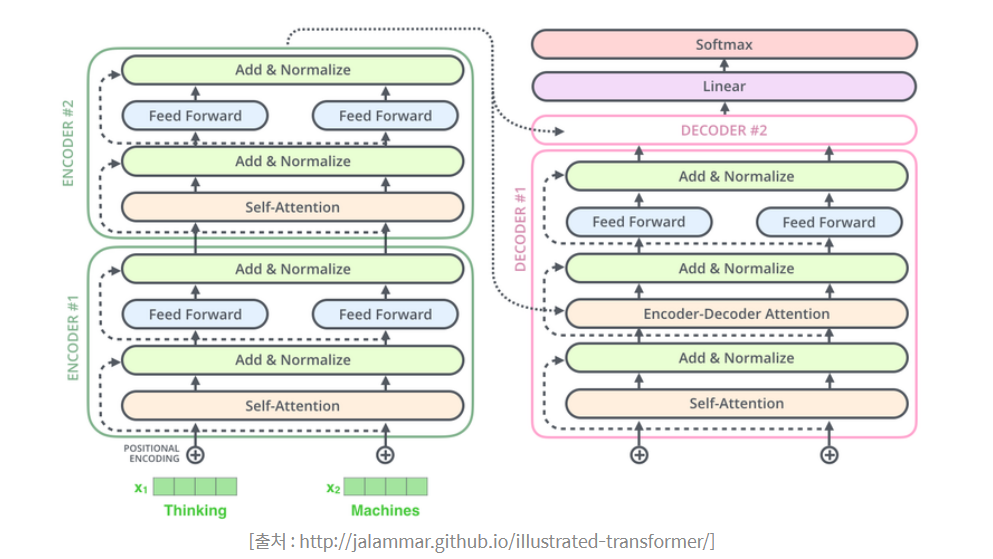

<br><br>


### 4.1 포지셔널 인코딩(Positional Encoding)

<br>

**트랜스포머 모델의 입력 데이터 처리**  
- **임베딩 벡터에 포지셔널 인코딩(positional Encoding)을 더해준 뒤에 입력으로 사용**
- **문장에 있는 모든 단어를 한꺼번에 입력으로 받기 때문에 포지셔널 인코딩(positional Encoding) 필요**
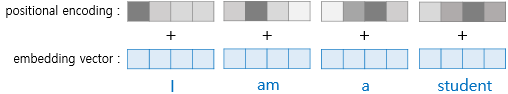

<br><br>


**포지셔널 인코딩의 벡터값에 대한 수식**

$$
PE_{(pos,~2i)} = sin\left(\frac{pos}{10000}^{\frac{2i}{d_{model}}}\right)
$$

$$
PE_{(pos,~2i+1)} = cos\left(\frac{pos}{10000}^{\frac{2i}{d_{model}}}\right)
$$


**수식의 용어 설명**

- $d_{model}$ : **임베딩 벡터의 차원을 의미**
- $pos$ : **입력 문장에서의 임베딩 벡터의 위치 정보**
- $i$ : **임베딩 벡터 내의 차원의 인덱스를 의미**
- **임베딩 행렬과 포지셔널 행렬이라는 두 행렬을 더함으로써 각 단어 벡터에 위치 정보 파악**
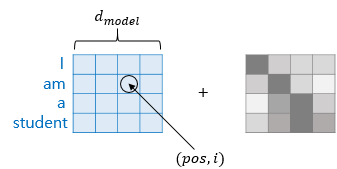


<br><br>

**실제 논문에서 사용한 포지셔널 인코딩을 표현 그림**
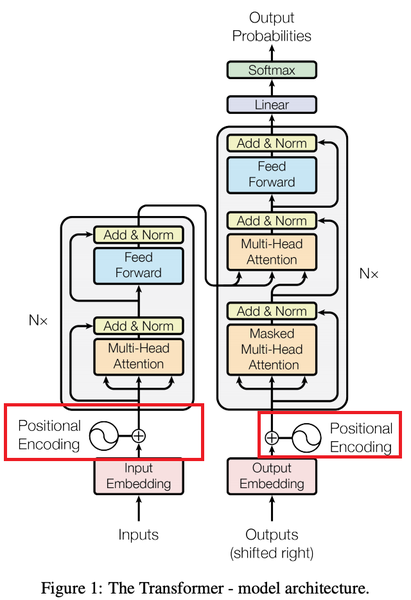

<br><br>

### **PositionalEncoding에 사용된 함수**

**tf.pow(x, y)함수**

- **출력값 : $x^y$을 출력**
- **예제**
    
    ```python
    x = tf.constant([[2, 2], [3, 3]])
    y = tf.constant([[8, 16], [2, 3]])
    tf.pow(x, y)  # [[256, 65536], [9, 27]]
    ```
    

**tf.cast(x, tf.float32) == tf.dtypes.cast()**

- **x의 dtype을 tf.float32로 변환**
- **변환 가능 타입**
    - **uint8, uint16, uint32, uint64, int8, int16, int32, int64, float16, float32, float64, complex64, complex128, bfloat16, complex64, complex128, xcomplex64, complex128**
    

**tf.newaxis**

- **차원변경**
- **train_x [..., tf.newaxis]
[] 안에 기존의 배열을...으로 적고, 추가하고 싶은 위치에 tf.newaxis를 적어주면 간단히 size 변경**
- **예제**
    
    ```python
    print(train_x[..., tf.newaxis].shape)
    '''
    (60000, 28, 28, 1)
    '''
    ```
    

**tf.stack(values, axis=0, name='stack’)**

- **텐서 배열을 1차원 높은 단계로 패킹**
- **예제**
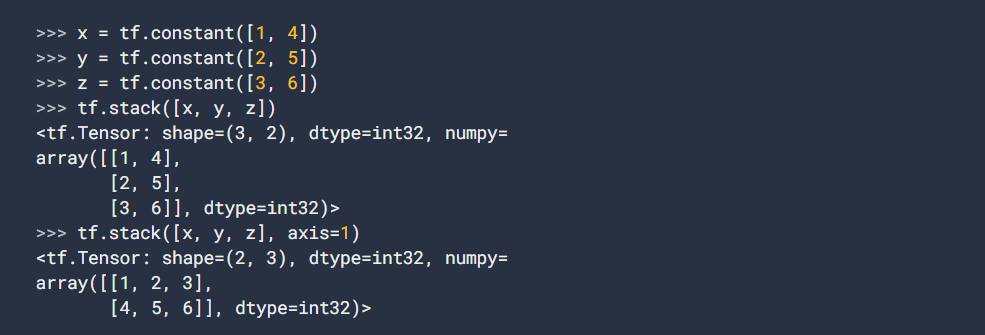

In [17]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                                     i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], 
                                     d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

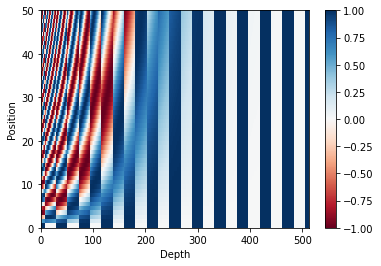

In [18]:
# 최대 문장의 길이가 50이고 워드 임베딩 차원을 512로 하는 모델의 입력 벡터 모양
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 4.2 인코더

### 4.2.1 **어텐션이란?**

---

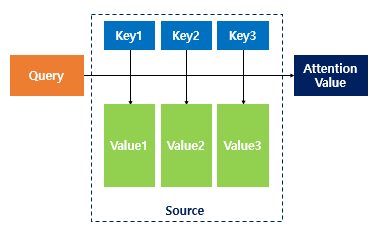

**어텐션 함수**

- **주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구하기**
- **구해낸 이 유사도를 키(Key)와 맵핑되어있는 각각의 '값(Value)'에 반영**
- **유사도가 반영된 '값(Value)'을 모두 더해서 뭉치기**
- **이것이 최종 결과인 어텐션 값(Attention Value)**

<br>

### 4.2.2 **트랜스포머에서 사용된 어텐션**

---

**트랜스포머는 총 세 가지의 어텐션을 사용**

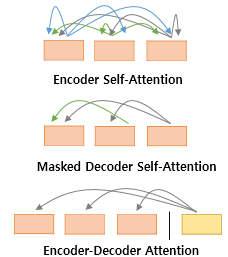

**첫 번째 그림 : 인코더 셀프 어텐션 → 인코더에 위치**

**두 번째 그림 : 디코더 셀프 어텐션 → 디코더에 위치**

**세 번째 그림 : 인코더-디코더 어텐션 → 디코더에 위치**

<br>

**트랜스포머의 전체적인 아키텍처에서 각 어텐션이 위치한 곳**
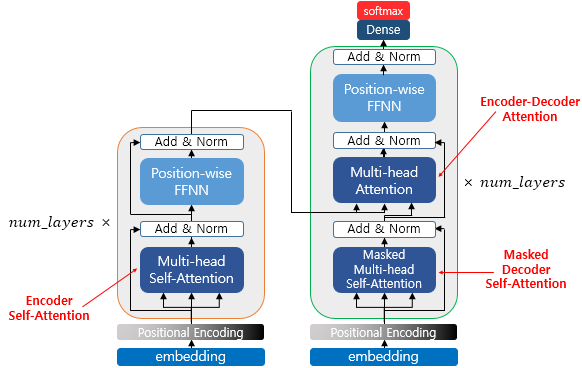



**트랜스포머의 어텐션 함수에 사용되는 쿼리(Query), 키(Key), 밸류(Value) 는 
기본적으로 '단어 (정보를 함축한) 벡터'**

**'단어 벡터' 란  트랜스포머의 여러 연산을 거친 후의 단어 벡터**

<br>

**세 가지 어텐션에 대한 설명**

- **인코더 셀프 어텐션**
    - **인코더의 입력으로 들어간 문장 내 단어들이 서로의 유사도 구한다.**
- **디코더 셀프 어텐션**
    - **단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.**
- **인코더-디코더 어텐션**
    - **디코더가 잘 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.**

**세 가지 어텐션 중 두 가지가 셀프 어텐션**

<br><br>

### **4.2.3 셀프 어텐션(Self Attention)**

---

**셀프 어텐션**

- **유사도를 구하는 대상이 다른 문장의 단어가 아니라 현재 문장 내의 단어들이 서로 유사도를 구하는 경우**

**인코더-디코더 어텐션**

- **서로 다른 단어 목록(인코더 내 단어와 디코더 내 단어) 사이에서 유사도를 구하기에 셀프 어텐션이 아니다.**

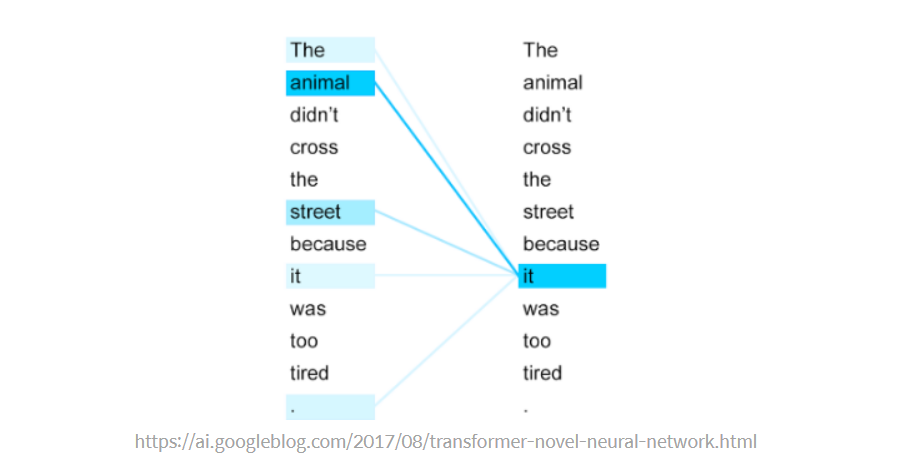

**위의 그림은 [구글 AI 블로그 포스트](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)에서 가져왔습니다.   
위의 예시 문장을 번역하면 '그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.' 라는 의미가 됩니다.** 

**그런데 여기서 그것(it) 에 해당하는 것은 과연 길(street) 일까요? 동물(animal) 일까요?**

**셀프 어텐션은 입력 문장 내의 단어들끼리 유사도를 구하여 그것(it) 이 동물(animal) 과 연관되었을 확률이 높다는 것을 찾아냅니다.  
그런데 한 가지 의문이 듭니다. 유사도는 어떻게 구할까요?**

<br><br>

### 4.2.4 스케일드 닷 프로덕트 어텐션

**트랜스포머에서는 어텐션 값을 구하는 방법으로 아래와 같은 수식을 사용**

$$
Attention(Q,K,V)=softmax\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

$Q$, $K$, $V$는 각각 **쿼리(Query), 키(Key), 값(Value)**

<br>

**어텐션 함수**

- **주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구하기**
- **구해낸 이 유사도를 키(Key)와 맵핑되어있는 각각의 '값(Value)'에 반영**
- **유사도가 반영된 '값(Value)'을 모두 더해서 뭉치기**
- **이것이 최종 결과인 어텐션 값(Attention Value)**

**어텐션 함수 정의와 아래 내용 세 가지만 기억하면 수식을 그림으로 정리 가능**

- **Q, K, V : 단어 벡터를 행으로 하는 문장 행렬**
- **벡터의 내적(dot product) : 벡터의 유사도를 의미**
- **특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링(Scaling)을 위함**

---

$Q$와 $K$의 **전치 행렬을 곱하는 것을 그림으로 표현하면 다음과 같습니다.**

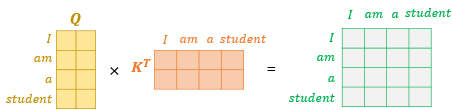

**문장 행렬 $Q$와 문장 행렬 $K$를 곱하면 위의 그림과 같은 초록색 행렬을 얻을 수 있습니다.**

**초록색 행렬이 의미하는 값은 무엇일까요?   
 'am' 행과 'student' 열의 값은 $Q$ 행렬에 있던 'am' 벡터와 $K$ 행렬에 있던 'student 벡터'의 내적값각 단어 벡터의 유사도가 모두 기록된 유사도 행렬이 되는 것**

---

$Q$와 $K$의 **유사도를 구하는 과정**

- **유사도 값을 스케일링 해주기 위해서 행렬 전체를 특정 값으로 나눠주기**
- **유사도를 0과 1사이의 값으로 Normalize해주기 위해서 소프트맥스 함수를 사용합**

**어텐션 값(Attention Value) → $Q$와 $K$의 유사도를 구하는 과정에 문장 행렬 $V$와 곱한 값**

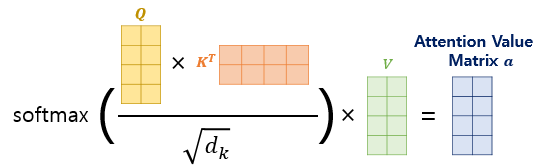

**결국 이를 모두 하나의 그림으로 표현하면 위와 같습니다.**

$$
Attention(Q,K,V)=softmax\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

**스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention)** 

- **내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 $Q$와 $K$의 유사도를 구한 방식**
- **유사도를 구하는 방법이 스케일드 닷 프로덕트(scaled dot product)였기 때문에 붙은 이름**

**만약에 분모에 특정 값을 나눠주는 부분을 사용하지 않았다면 어텐션의 이름은 무엇일까요? 그 어텐션은 당연히 닷 프로덕트 어텐션(dot product attention) 이라고 부릅니다.**

In [19]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


### **4.2.5 병렬로 어텐션 수행하기**

---

**트랜스포머에서 num_heads라는 변수**

- **기계가 몇 개의 똑똑한 머리를 사용할지, 병렬적으로 몇 개의 어텐션 연산을 수행할지를 결정하는 하이퍼파라미터**

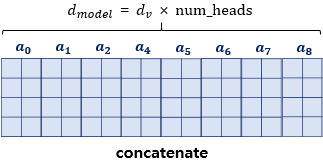

**d_model : 임베딩 벡터의 차원** 

**트랜스포머의 초기 입력인 문장 행렬의 크기**

- **행 : 문장의 길이**
- **열 : d_model의 길이**

**트랜스포머는**

- **입력된 문장 행렬을 num_heads의 수만큼 쪼개서 어텐션을 수행**
- **얻은 num_heads의 개수만큼의 어텐션 값 행렬을 다시 하나로 concatenate**

**그림은 num_heads가 8개인 경우인데, 다시 concatenate하면서 열의 크기가 d_model이 됩니다.**

**각자 문제지를 나눠서 푼 후에 마지막에 다시 결과를 합친다고 비유해볼 수도 있겠네요!**


<br><br>

### **4.2.6 멀티-헤드 어텐션**

---

**이렇게 병렬로 어텐션을 수행하면 얻을 수 있는 효과는 무엇일까요?**

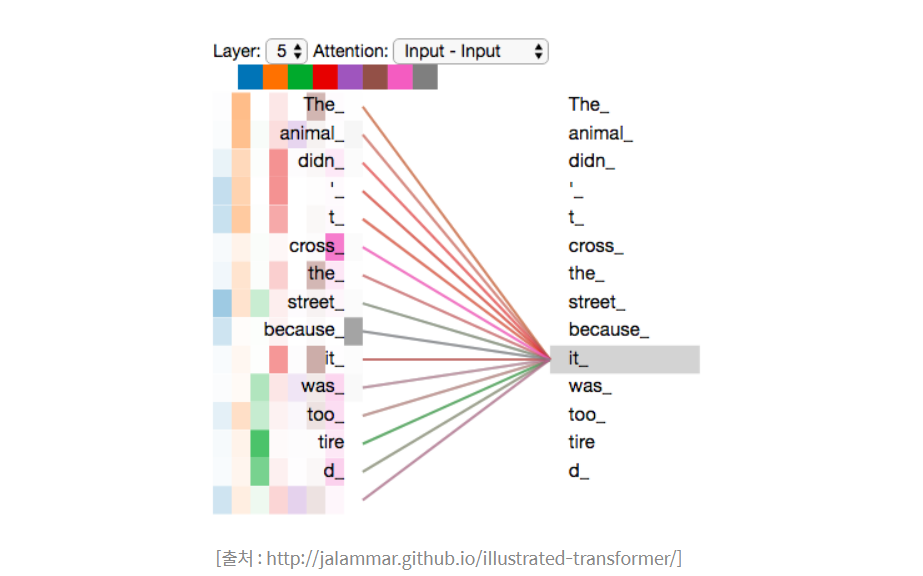

**그림은 num_heads의 값이 8일 때, 병렬로 수행되는 어텐션이 서로 다른 셀프 어텐션 결과를 얻을 수 있음을 보여줍니다.  
다시 말해 8개의 머리는 각각 다른 관점에서 어텐션을 수행하므로 한 번의 어텐션만 수행했다면 놓칠 수도 있던 정보를 캐치 가능  
예를 들어 위 그림에서라면 it_이라는 토큰이 animal_과 유사하다고 보는 관점과 street_과 유사하다고 보는 관점이 한꺼번에 모두 표현 가능하다는 뜻입니다.**

**멀티 헤드 어텐션 : 어텐션을 병렬로 수행하는 것**

In [20]:
# 멀티 헤드 어텐션을 구현 - 내부적으로는 스케일드 닷 프로덕트 어텐션 함수를 호출
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### **4.2.7 마스킹**

**마스킹(Masking) 이란, 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법**

**트랜스포머에서는 어텐션을 위해서 패딩, 룩 어헤드 마스킹을 사용**

<br>


### **4.2.7.1 패딩 마스킹(Padding Masking)**

---

**패딩 마스킹은 패딩 토큰(Padding token)을 이용한 방법**

**자연어 처리에서 패딩(Padding)이란?**

**패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법**

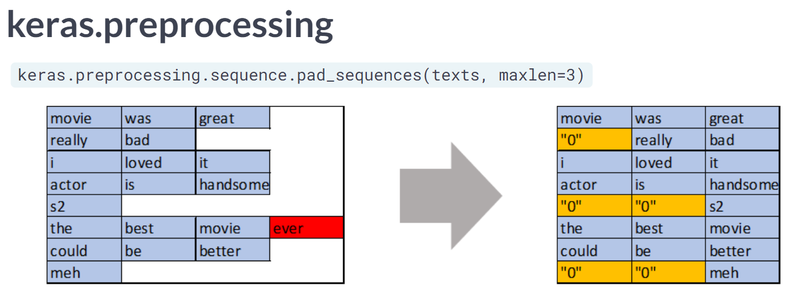
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**케라스의 pad_sequences()를 사용하여 패딩을 하는 과정을 시각화한 그림**

<br>

**숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외하기 위해  
패딩 마스킹은 이를 위해 숫자 0인 위치를 체크합니다.**


**패딩마스크 함수에 정수 시퀀스를 입력으로 하면, 이 함수는 숫자가 0인 부분을 체크한 벡터를 리턴**

- **숫자가 0이면 1을 반환**


In [21]:
# 패딩 마스킹을 구현한 함수
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

### 4.2.7.2 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

**트랜스포머**

---

**트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있습니다. 하지만 사실 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것입니다. 따라서 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법입니다.**

**이 기법은 어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹 합니다.**

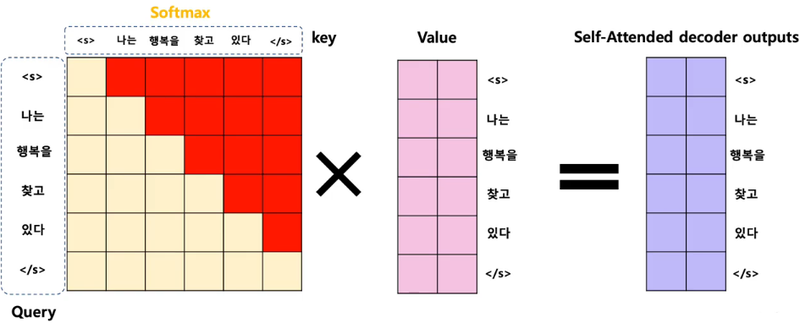
[![김동화 - t=Transformer &bert](http://img.youtube.com/vi/xhY7m8QVKjo/0.jpg)](https://www.youtube.com/watch?v=xhY7m8QVKjo)

<br><br>

**그림에서 빨간색으로 색칠된 부분은 마스킹을 표현
빨간색은 실제 어텐션 연산에서 가리는 역할을 하여 어텐션 연산 시에 현재 단어를 기준으로 이전 단어들하고만 유사도를 구할 수 있습니다. 행을 Query, 열을 Key로 표현된 행렬임을 감안하고 천천히 행렬을 살펴봅시다.**

**Query 단어가 '찾고'라고 한다면, 이 '찾고'라는 행에는 \<s>, <나는>, <행복을>, <찾고>까지의 열만 보이고 그 뒤 열은 아예 빨간색으로 칠해져 있습니다.  
즉, 유사도를 구할 수 없도록 해놓았습니다. 저 빨간색 부분을 마스킹 함수로 구현하면 다음과 같습니다.**

**look ahead 마스킹 함수 구현**
- **create_look_ahead_mask()함수는 내부적으로 앞서 구현한 패딩 마스크 함수도 호출**


In [22]:
# 패딩 & look ahead 마스킹 함수 구현
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

## 4.2.8. 인코더

### **4.2.8.1 인코더 층 만들기**


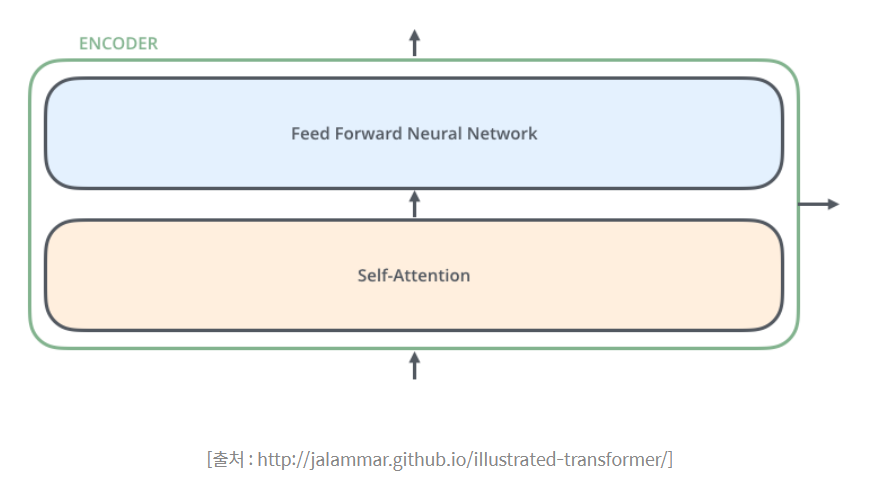

**하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)**

- **셀프 어텐션**
    - **멀티 헤드 어텐션으로 병렬적으로 이루어짐**
- **피드 포워드 신경망**

<br><br>
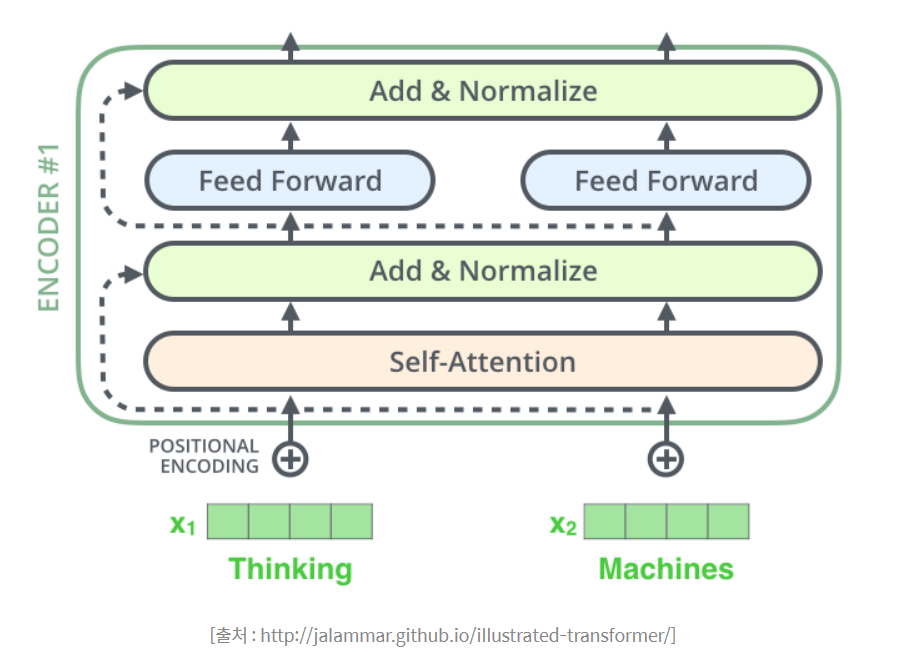


In [23]:
# 두 개의 서브 층을 가지는 하나의 인코더 층을 구현 
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, 
                                   num_heads, 
                                   name="attention")({'query': inputs, 'key': inputs, 'value': inputs, 'mask': padding_mask})

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### **4.2.8.2 인코더 층을 쌓아 인코더 만들기**

---

**구현한 인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성**

**인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용  
위 그림에서는 Normalize라고 표시된 부분에 해당.**

**트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓습니다. 논문에서는 총 6개의 인코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.**

In [24]:
# 인코더 층을 쌓아 인코더 만들기
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(units=units, 
                                d_model=d_model, 
                                num_heads=num_heads, 
                                dropout=dropout, 
                                name="encoder_layer_{}".format(i),)([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 4. 3디코더

### **4.3.1 디코더 층**

---

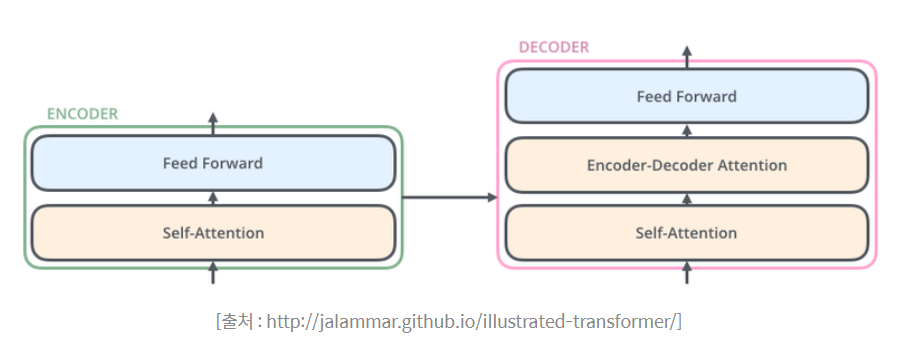

**첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망입니다.** 

<br>

**인코더-디코더 어텐션**

- **Query가 디코더의 벡터**
- **Key와 Value가 인코더의 벡터**
    - **인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정**

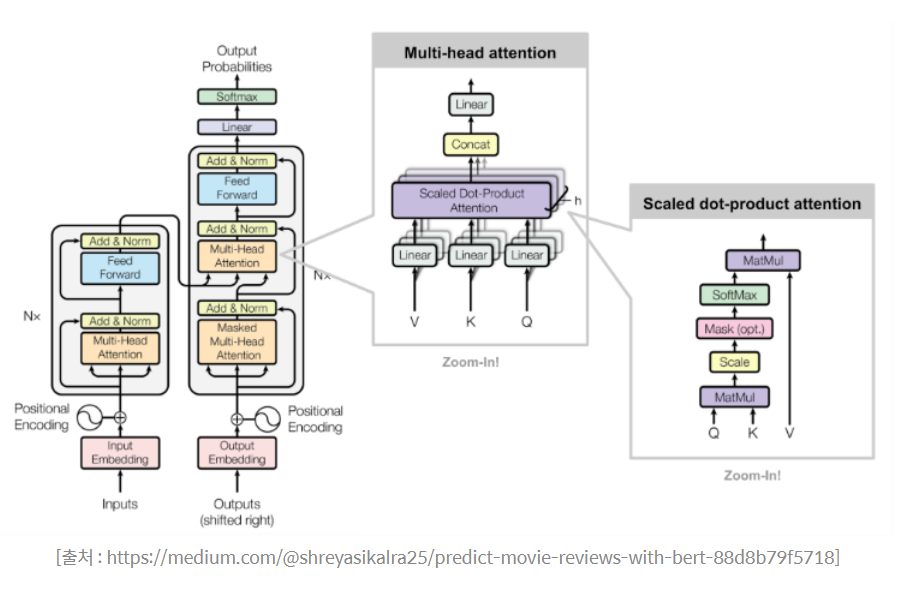

**디코더의 셀프 어텐션, 인코더-디코더 어텐션** 
- **스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행**

In [25]:
# 디코더의 세 개의 서브 층을 내부적으로 구현한 디코더의 함수
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, 
        name="attention_1")(inputs={'query': inputs, 'key': inputs, 'value': inputs, 'mask': look_ahead_mask})

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, 
        name="attention_2")(inputs={'query': attention1, 'key': enc_outputs, 'value': enc_outputs, 'mask': padding_mask})

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)


### **4.3.2 디코더 층을 쌓아 디코더 만들기**

---

**디코더의 층은 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결  
사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성**

**num_layers 개수 만큼의 디코더 층을 쌓습니다.**

In [26]:
# 디코더 층을 쌓아 디코더 만들기
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(units=units, 
                                d_model=d_model, 
                                num_heads=num_heads, 
                                dropout=dropout, 
                                name='decoder_layer_{}'.format(i),)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

### 4.4 인코더 , 디코더 함수를 이용해 Transformer 함수 정의

In [27]:
# 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(vocab_size=vocab_size, 
                          num_layers=num_layers, 
                          units=units, 
                          d_model=d_model, 
                          num_heads=num_heads, 
                          dropout=dropout, ) (inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(vocab_size=vocab_size, 
                          num_layers=num_layers, 
                          units=units, d_model=d_model, 
                          num_heads=num_heads, 
                          dropout=dropout, )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 4.5 Transformer 모델 생성

In [28]:
# 모델생성
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(vocab_size=VOCAB_SIZE, 
                    num_layers=NUM_LAYERS, 
                    units=UNITS, 
                    d_model=D_MODEL, 
                    num_heads=NUM_HEADS, 
                    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3148288     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 4.6 손실 함수(Loss function)
- **레이블인 시퀀스에 패딩이 되어 있으므로, 패딩 마스크를 적용하여 loss를 계산**

In [29]:
# 손실함수 구현
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 4.7 커스텀 된 학습률(Learning rate)
- **모델학습 초기에 learning rate를 급격히 높였다가,  
이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용**

<br>

**논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용**

**논문에 나온 공식은 다음과 같습니다.**


$$
lrate=d^{-0.5}_{model}⋅min(step\_num^{−0.5},~step\_num⋅warmup\_steps^{−1.5})
$$

$step\_num^{-0.5}$에 비례하는 부분과 $step\_num$에 비례하는 부분 중 작은 쪽을 택하도록 되어 있어서  
학습 초기에는 learning_rate가 $step\_num$에 비례해서 증가하다가 이후로는 감소하는 것을 확인 가능


In [30]:
# 커스텀 학습률 스케줄링(Custom Learning rate Scheduling) 클래스 구현
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 4.7.1 커스텀 된 학습률(Learning rate) 시각화

Text(0.5, 0, 'Train Step')

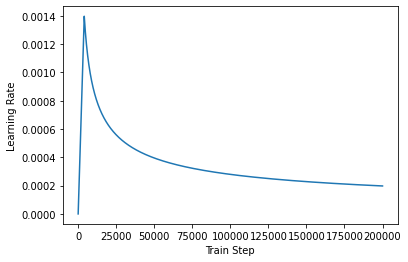

In [31]:
# 커스텀 학습률 스케줄링 계획을 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 4.8 모델 컴파일
- **손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일**

In [32]:
# 손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 4.9 훈련

In [33]:
# 훈련하기
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 23s 51ms/step - loss: 1.4484 - accuracy: 0.0216
Epoch 2/50
185/185 [==============================] - 9s 51ms/step - loss: 1.1795 - accuracy: 0.0491
Epoch 3/50
185/185 [==============================] - 9s 51ms/step - loss: 1.0056 - accuracy: 0.0508
Epoch 4/50
185/185 [==============================] - 10s 52ms/step - loss: 0.9296 - accuracy: 0.0544
Epoch 5/50
185/185 [==============================] - 10s 52ms/step - loss: 0.8712 - accuracy: 0.0577
Epoch 6/50
185/185 [==============================] - 10s 52ms/step - loss: 0.8115 - accuracy: 0.0616
Epoch 7/50
185/185 [==============================] - 10s 52ms/step - loss: 0.7466 - accuracy: 0.0676
Epoch 8/50
185/185 [==============================] - 10s 53ms/step - loss: 0.6737 - accuracy: 0.0755
Epoch 9/50
185/185 [==============================] - 10s 54ms/step - loss: 0.5943 - accuracy: 0.0840
Epoch 10/50
185/185 [==============================] - 10s 54ms/step - loss: 0.5124 

## **Step 5. 모델 평가 하기**

**예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.**

- **새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.**
- **입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.**
- **패딩 마스킹과 룩 어헤드 마스킹을 계산한다.**
- **디코더는 입력 시퀀스로부터 다음 단어를 예측한다.**
- **디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.**
- **END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.**

### 5.1 테스트문장 전처리 함수
- \[ ?, ., !\]와 같은 구두점을 제거하지 않고 구두점 앞에 공백(띄어쓰기)를 추가하여 다른 문자들과 구분

In [34]:
def preprocess_sentence(sentence):
    # 단어와 구두점 사이에 공백 추가.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

### 5.2 decoder_inference()함수를 만들기

In [35]:
# decoder_inference()함수를 만들기
def decoder_inference(sentence):
    # 테스트 문장 전처리
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

### 5.3 sentence_generation()함수 구현
- **입력 문장에 대해서 decoder_inference()함수를 호출하여 챗봇의 대답을 얻는 sentence_generation()함수**

In [36]:
# sentence_generation()함수 구현
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print(f'입력 : {sentence}'.format(sentence))
    print(f'출력 : {predicted_sentence}'.format(predicted_sentence))

    return predicted_sentence

### 5.4 챗봇 테스트

In [37]:
# 임의의 문장으로부터 챗봇의 대답 얻기1
sentence_generation('오늘 기분이 별로야')

입력 : 오늘 기분이 별로야
출력 : 신나는 음악 들어보세요 .


'신나는 음악 들어보세요 .'

In [38]:
# 임의의 문장으로부터 챗봇의 대답 얻기2
sentence_generation("아 힘들어")

입력 : 아 힘들어
출력 : 지금은 힘들겠지만 조금만 더 견뎌봐요 .


'지금은 힘들겠지만 조금만 더 견뎌봐요 .'

In [39]:
# 임의의 문장으로부터 챗봇의 대답 얻기3
sentence_generation("정신없다")

입력 : 정신없다
출력 : 힘내세요 !  제가 응원할게요 .


'힘내세요 !  제가 응원할게요 .'

In [40]:
# 임의의 문장으로부터 챗봇의 대답 얻기4
sentence_generation("너무 잠이 와")

입력 : 너무 잠이 와
출력 : 일찍 주무세요 .


'일찍 주무세요 .'

In [41]:
# 임의의 문장으로부터 챗봇의 대답 얻기5
sentence_generation("방학이 다가오고 있어")

입력 : 방학이 다가오고 있어
출력 : 학생이 아니니 어쩔 수 없죠 .


'학생이 아니니 어쩔 수 없죠 .'

생각보다 그리 좋은 답변이 아니라서.. 다시 도전

## Step6 - 6 layer, $ d_{model} = 512 $, max_len = 21
- 전체적인 문자의 길이가 21을 넘어가지 않아서 굳이 문장을 길게 할 필요가 없을 것 같아서 max_len=21로 설정

In [42]:
# github에서 직접 데이터 가져오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.sample(10)

,Q,A,label
2681,스테이크 썰고 싶다,집에서도 할 수 있어요.,0
4018,재밌는거 해 줘,거울을 보면서 얼굴 망가뜨리기 놀이 해 보신 적 있으세요? 의외로 재미 있어요.,0
4004,장학금 가능할까?,열심히 하면 받을 수 있을 거예요.,0
456,낌새가 이상하더니 딱 걸렸어,잘 해결되길 바라요.,0
3476,요즘 드라마가 땡겨,저도 드라마 좋아해요.,0
3374,오로라 보러 여행 가고 싶다,로맨틱한 여행이네요.,0
3812,일기 써야 되는데,나중에 보면 좋은 추억이 될 거예요.,0
2313,살 게 없네,안 사면 그만큼 모으시는거예요.,0
1661,며칠 전에 다시 만났는데,좋은 만남이었길 바라요.,0
3935,자유시간 갖고 싶어,자신만의 시간이 필요한가봐요.,0


In [43]:
# questions에 대한 전처리
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

# answer에 대한 전처리
answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [44]:
# 단어장 만들기
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# 정수가 겹치지 않게 하지 위해 단어장의 크기와 그보다 1이 큰 수를 번호로 부여
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2

In [45]:
# 패딩 최대 길이 정의
MAX_LENGTH = 21

# 정수 인코딩, 최대 길이로 패딩 함수 구현
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

# 정수 인코딩, 패딩 적용
questions, answers = tokenize_and_filter(questions, answers)

In [46]:
# 인코더와 디코더의 입력, 그리고 레이블 만들기
BATCH_SIZE = 64
BUFFER_SIZE = 50000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [47]:
# 모델생성
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model_1 = transformer(vocab_size=VOCAB_SIZE, 
                    num_layers=NUM_LAYERS, 
                    units=UNITS, 
                    d_model=D_MODEL, 
                    num_heads=NUM_HEADS, 
                    dropout=DROPOUT)

model_1.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13656064    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [48]:
model_1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [49]:
# 훈련하기
EPOCHS = 50
model_1.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 40s 132ms/step - loss: 2.2445 - accuracy: 0.0488
Epoch 2/50
185/185 [==============================] - 25s 134ms/step - loss: 2.1418 - accuracy: 0.0529
Epoch 3/50
185/185 [==============================] - 24s 132ms/step - loss: 2.0884 - accuracy: 0.0553
Epoch 4/50
185/185 [==============================] - 24s 132ms/step - loss: 2.0727 - accuracy: 0.0560
Epoch 5/50
185/185 [==============================] - 24s 132ms/step - loss: 2.0625 - accuracy: 0.0557
Epoch 6/50
185/185 [==============================] - 24s 132ms/step - loss: 2.0557 - accuracy: 0.0561
Epoch 7/50
185/185 [==============================] - 24s 132ms/step - loss: 2.0499 - accuracy: 0.0565
Epoch 8/50
185/185 [==============================] - 25s 133ms/step - loss: 2.0464 - accuracy: 0.0566
Epoch 9/50
185/185 [==============================] - 24s 132ms/step - loss: 2.0426 - accuracy: 0.0566
Epoch 10/50
185/185 [==============================] - 25s 132ms/step - l

In [50]:
# 임의의 문장으로부터 챗봇의 대답 얻기1
sentence_generation('오늘 기분이 별로야')

입력 : 오늘 기분이 별로야
출력 : 신나는 음악 들어보세요 .


'신나는 음악 들어보세요 .'

In [51]:
# 임의의 문장으로부터 챗봇의 대답 얻기2
sentence_generation("아 힘들어")

입력 : 아 힘들어
출력 : 지금은 힘들겠지만 조금만 더 견뎌봐요 .


'지금은 힘들겠지만 조금만 더 견뎌봐요 .'

In [52]:
# 임의의 문장으로부터 챗봇의 대답 얻기3
sentence_generation("정신없다")

입력 : 정신없다
출력 : 힘내세요 !  제가 응원할게요 .


'힘내세요 !  제가 응원할게요 .'

In [53]:
# 임의의 문장으로부터 챗봇의 대답 얻기4
sentence_generation("너무 잠이 와")

입력 : 너무 잠이 와
출력 : 일찍 주무세요 .


'일찍 주무세요 .'

In [54]:
# 임의의 문장으로부터 챗봇의 대답 얻기5
sentence_generation("방학이 다가오고 있어")

입력 : 방학이 다가오고 있어
출력 : 학생이 아니니 어쩔 수 없죠 .


'학생이 아니니 어쩔 수 없죠 .'

답변이 왔다갔다 하는 듯..  accuracy가 너무 안좋다.. loss는 너무 크다
다시 도전..
## Step 6.2 2번째 도전 : 3 layer, $ d_{model} = 256 $, max_len = 20

In [55]:
# github에서 직접 데이터 가져오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.sample(5)

,Q,A,label
1091,늘 빡빡하게 살기 힘드네,여유가 생기길 바랍니다.,0
1710,모른 척 하는 건지 모르는 건지,진짜 모르는 걸 수도 있어요.,0
3436,왜 살까,살아있음 자체로 의미가 있으니까요.,0
2739,시어머니가 차별해,진실되게 대하면 시어머니도 알아주실거예요.,0
6862,아직도 많이 죽을것같아,잠깐 쉬어가도 괜찮아요.,1


In [56]:
# questions에 대한 전처리
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

# answer에 대한 전처리
answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [57]:
# 단어장 만들기
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# 정수가 겹치지 않게 하지 위해 단어장의 크기와 그보다 1이 큰 수를 번호로 부여
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2

In [58]:
# 패딩 최대 길이 정의
MAX_LENGTH = 20

# 정수 인코딩, 최대 길이로 패딩 함수 구현
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

# 정수 인코딩, 패딩 적용
questions, answers = tokenize_and_filter(questions, answers)

In [59]:
# 인코더와 디코더의 입력, 그리고 레이블 만들기
BATCH_SIZE = 64
BUFFER_SIZE = 50000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [60]:
# 모델생성
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 3 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model_2 = transformer(vocab_size=VOCAB_SIZE, 
                    num_layers=NUM_LAYERS, 
                    units=UNITS, 
                    d_model=D_MODEL, 
                    num_heads=NUM_HEADS, 
                    dropout=DROPOUT)

model_2.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3675392     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [61]:
model_2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [62]:
# 훈련하기
EPOCHS = 50
model_2.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 16s 47ms/step - loss: 2.2433 - accuracy: 0.0856
Epoch 2/50
185/185 [==============================] - 9s 47ms/step - loss: 1.9256 - accuracy: 0.1072
Epoch 3/50
185/185 [==============================] - 9s 47ms/step - loss: 1.8421 - accuracy: 0.1112
Epoch 4/50
185/185 [==============================] - 9s 47ms/step - loss: 1.7739 - accuracy: 0.1134
Epoch 5/50
185/185 [==============================] - 9s 47ms/step - loss: 1.6927 - accuracy: 0.1184
Epoch 6/50
185/185 [==============================] - 9s 47ms/step - loss: 1.6030 - accuracy: 0.1238
Epoch 7/50
185/185 [==============================] - 9s 47ms/step - loss: 1.5061 - accuracy: 0.1305
Epoch 8/50
185/185 [==============================] - 9s 47ms/step - loss: 1.3963 - accuracy: 0.1403
Epoch 9/50
185/185 [==============================] - 9s 47ms/step - loss: 1.2733 - accuracy: 0.1531
Epoch 10/50
185/185 [==============================] - 9s 46ms/step - loss: 1.1412 - accur

In [63]:
# 임의의 문장으로부터 챗봇의 대답 얻기1
sentence_generation('오늘 기분이 별로야')

입력 : 오늘 기분이 별로야
출력 : 신나는 음악 들어보세요 .


'신나는 음악 들어보세요 .'

In [64]:
# 임의의 문장으로부터 챗봇의 대답 얻기2
sentence_generation("아 힘들어")

입력 : 아 힘들어
출력 : 지금은 힘들겠지만 조금만 더 견뎌봐요 .


'지금은 힘들겠지만 조금만 더 견뎌봐요 .'

In [65]:
# 임의의 문장으로부터 챗봇의 대답 얻기3
sentence_generation("정신없다")

입력 : 정신없다
출력 : 힘내세요 !  제가 응원할게요 .


'힘내세요 !  제가 응원할게요 .'

In [66]:
# 임의의 문장으로부터 챗봇의 대답 얻기4
sentence_generation("너무 잠이 와")

입력 : 너무 잠이 와
출력 : 일찍 주무세요 .


'일찍 주무세요 .'

In [67]:
# 임의의 문장으로부터 챗봇의 대답 얻기5
sentence_generation("방학이 다가오고 있어")

입력 : 방학이 다가오고 있어
출력 : 학생이 아니니 어쩔 수 없죠 .


'학생이 아니니 어쩔 수 없죠 .'

## 회고

1. 이번 프로젝트에서 **어려웠던 점,**

- transformer의 구조를 파악이 쉽지는 않았다.
- 처음부터 따라가는 것이 힘들어 시간이 많이 들었다

2. 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 알아낸 점
    - 대략적인 transformer의 구조
    - 자연어처리를 하는 대략적인 방법
    - 수식 정리
    
- 아직 모호한 점
    - 문장 길이가 길지 않는 데, 길게 해야 하는건가??
    - accuracy가 나오지 않는 데, 구문이 완성되는 것이 신기했음..    
    - 이것의 평가지표는 accuracy인가? 아님 그냥 이것도 인간이 판단하는 건가?
    - 어떤 것을 변경해야지 좋아지는 것인지 아직 애매해다...
    
3. 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- layer개수 , $ d_{model} $ 바꾸기, max_len 바꾸기, epoch 늘이기

4. 자기다짐
- 매번 exploration을 진행하다 보면 지치는 것 같다.  
- 깊게 들어가기 위해서는 시간이 많이 필요하다.. 잘 하고 있는 지 모르겠다.....